In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from pathlib import Path
import torch
import pickle

from modules import optimize_ML
from modules.elbo import ELBO

### Run curvature estimation for 100 different trajectories to test recovery 

In [ ]:
sim_idx = 0 # which out of the 100 simulated trajectories to use
n_traj = 50
n_bootstrap = 20
data_path = Path('data')
c_true = np.zeros((n_traj, n_bootstrap)) # simulated global curvature
c_est = np.zeros((n_traj, n_bootstrap))  # average estimated local curvature

for i in range(n_traj):
    for j in range(n_bootstrap):
        try:
            # load data
            f_name = f'sim_{str(i+1).zfill(4)}.mat'
            S = spio.loadmat(Path(data_path) / f_name)['S']
            S_list = [S[0, i] for i in range(S.shape[1])]  # convert to list of structs
            c_true[i, j] = np.mean(np.rad2deg(S_list[sim_idx]['c'][0, 0]).flatten())
            
            # unpack data
            n_corr_obs = S_list[sim_idx]['Pc_reshaped'][0, 0] * S_list[sim_idx]['num_trials_mat'][0, 0]
            n_total_obs = S_list[sim_idx]['num_trials_mat'][0, 0]
            n_frames = S_list[sim_idx]['Pc_reshaped'][0, 0].shape[0]
            n_dim = 2

            elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=30000, verbose=False)
            x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post, _ = elbo.optimize_ELBO_SGD()            
            c_est[i, j] = torch.mean(torch.rad2deg(elbo.mu_post_c)).detach().numpy()
            print(f"Bootstrap: {j}")
        except:
            print(f"Bootstrap run {j} resulted in an error. Will be skipped for the analysis.")

    # save data 
    save_data = {'x_true': S_list[sim_idx]['x'][0, 0],
                 'x_pred': x, # currently only the last most likely trajectory is being saved
                 'perf_true': S_list[sim_idx]['Pc_reshaped'][0, 0],
                 'perf_pred': p.detach().squeeze(),
                 'c_true_sim': np.rad2deg(S_list[sim_idx]['c'][0, 0]).flatten(), 
                 'c_post': c_est[i],
                 'c_true': c_true[i]}

    f_name = Path('data') / 'curvatures' / f'curvature_{str(i+1).zfill(4)}.pkl'
    with open(f_name, 'wb') as f:
        pickle.dump(save_data, f)

    if not i % 10:
        print(f"Trajectory: {i}")

Bootstrap: 0
Bootstrap run 1 resulted in an error. Will be skipped for the analysis.
Bootstrap: 2
Bootstrap: 3
Bootstrap: 4
Bootstrap: 5
Bootstrap: 6
Bootstrap: 7
Bootstrap: 8
Bootstrap run 9 resulted in an error. Will be skipped for the analysis.
Bootstrap: 10
Bootstrap: 11
Bootstrap: 12
Bootstrap: 13
Bootstrap: 14
Bootstrap: 15
Bootstrap: 16
Bootstrap: 17
Bootstrap: 18
Bootstrap: 19
Trajectory: 0
Bootstrap: 0
Bootstrap: 1
Bootstrap: 2
Bootstrap: 3
Bootstrap: 4
Bootstrap: 5
Bootstrap: 6
Bootstrap: 7
Bootstrap: 8
Bootstrap: 9
Bootstrap: 10
Bootstrap: 11
Bootstrap: 12
Bootstrap: 13
Bootstrap: 14
Bootstrap: 15
Bootstrap: 16
Bootstrap: 17
Bootstrap: 18
Bootstrap: 19
Bootstrap: 0
Bootstrap run 1 resulted in an error. Will be skipped for the analysis.
Bootstrap run 2 resulted in an error. Will be skipped for the analysis.
Bootstrap: 3
Bootstrap: 4
Bootstrap: 5
Bootstrap: 6
Bootstrap: 7
Bootstrap: 8
Bootstrap: 9
Bootstrap: 10
Bootstrap: 11
Bootstrap: 12
Bootstrap run 13 resulted in an error.

### Visualization

In [54]:
# due to bug, the last saved file contains all trajectories over all bootstraps (n_trajectories x n_bootstraps)
with open(f_name, 'rb') as f:
    loaded_dict = pickle.load(f)

# replace failed bootstraps with NaN
data_c_est = loaded_dict['c_post']
failed_trials = [
    (0, 1), (0, 9),
    (2, 1), (2, 2), (2, 13), (2, 18),
    (3, 11), (3, 17),
    (4, 0), (4, 1), (4, 14),
    (5, 0), (5, 4),
    (6, 12),
    (7, 6), (7, 13),
    (8, 12), (8, 14),
    (9, 16), (9, 17),
    (10, 1), (10, 2), (10, 7), (10, 9), (10, 16), (10, 19),
    (11, 3), (11, 6), (11, 8),
    (12, 10), (12, 16), (12, 19),
    (13, 4), (13, 7), (13, 8), (13, 9), (13, 11), (13, 14), (13, 17),
    (14, 2),
    (15, 5), (15, 8),
    (16, 10), (16, 11), (16, 15), (16, 17),
    (17, 2), (17, 17), (17, 18),
    (18, 1), (18, 3), (18, 6), (18, 10), (18, 16), (18, 17),
    (19, 6), (19, 17), (19, 19),
    (20, 10), (20, 15),
    (21, 3), (21, 7),
    (22, 13),
    (23, 6), (23, 8), (23, 10),
    (24, 1), (24, 3), (24, 9), (24, 19),
    (25, 7), (25, 13),
    (26, 6), (26, 9), (26, 12), (26, 14), (26, 17), (26, 19),
    (27, 14), (27, 15), (27, 18), (27, 19),
    (28, 18),
    (29, 2), (29, 3),
    (30, 0), (30, 1), (30, 17),
    (31, 7), (31, 12), (31, 18),
    (32, 5),
    (33, 4), (33, 10), (33, 12), (33, 14), (33, 15),
    (34, 9), (34, 13),
    (35, 7), (35, 12), (35, 16),
    (36, 4), (36, 13),
    (37, 1), (37, 2), (37, 4),
    (38, 1), (38, 3), (38, 5), (38, 12),
    (39, 2), (39, 13), (39, 17),
    (40, 1),
    (41, 10), (41, 17),
    (42, 1), (42, 7),
    (43, 11),
    (44, 0), (44, 13), (44, 19),
    (45, 3), (45, 7),
    (46, 8), (46, 18),
    (47, 6), (47, 12), (47, 13), (47, 19),
    (48, 0), (48, 15),
    (49, 0), (49, 2), (49, 5), (49, 6), (49, 11), (49, 13)
]


for ifail in range(len(failed_trials)):
    data_c_est[failed_trials[ifail]] = np.nan

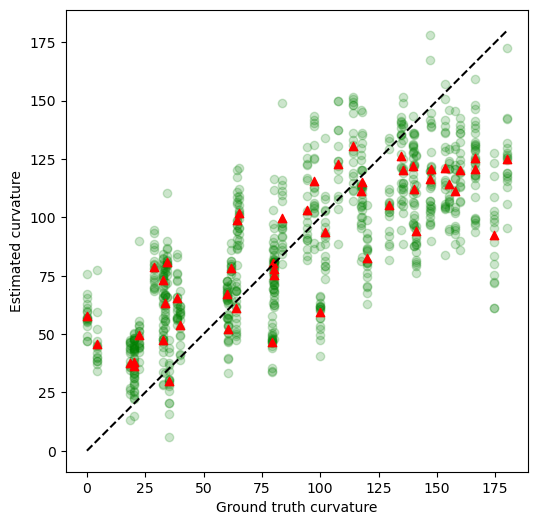

In [95]:
fig1, ax = plt.subplots(figsize=(10, 6))

ax.scatter(loaded_dict['c_true'], data_c_est, c='green', alpha=0.2)
ax.scatter(np.mean(loaded_dict['c_true'], axis=1), np.nanmean(data_c_est, axis=1), marker='^', c='red', alpha=1)
ax.plot([0, 180], [0, 180], 'k--')
ax.set_xlabel('Ground truth curvature')
ax.set_ylabel('Estimated curvature')
ax.set_box_aspect(1)

plt.show()